In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import parallel_plume_sim as pps

In [83]:
puff_data_filename = '~/DataAnalysis/data/puff_data/puff_data_20230123_131923.pickle'

# how many seconds to include per chunk?
max_time = 2

# maximum distance in x and y to consider puffs before ignoring them?
min_x = -5
max_x = 5
min_y = -5
max_y = 5

pps.read_puff_data.split_puff_data_into_smaller_dataframes_and_cull_old_puffs(puff_data_filename, 
                                                                              max_time, 
                                                                              min_x, max_x, 
                                                                              min_y, max_y)

Directory /home/flybot/DataAnalysis/data/puff_data/puff_data_20230123_131923 exists, contains 151 files.
Press enter to DELETE all of these files... (hit ctrl-c to exit)
Removed all files in:  /home/flybot/DataAnalysis/data/puff_data/puff_data_20230123_131923


In [48]:
# dir='~/DataAnalysis/data/puff_data/'

In [49]:
# dir_odor='~/DataAnalysis/data/Sprints/HighRes/'

In [50]:
# t=pd.read_hdf(dir_odor+'NotWindy/NotWindyMASigned.h5')
# t=pd.read_hdf(dir_odor+'Windy/WindyMASigned.h5')

In [67]:
steps = np.random.uniform(low=0, high=10, size=(n_points, 2))
# np.cumsum(steps, axis=0)

In [118]:
n_points = 20 * 60  # 200Hz for 1 minute, change as needed
step_size = 0.05  # meters

steps = np.random.uniform(low=-step_size, high=step_size, size=(n_points, 2))
points = np.cumsum(steps, axis=0)

points[:, 0] = (points[:, 0] - np.min(points[:, 0])) / (np.max(points[:, 0]) - np.min(points[:, 0])) * 10
points[:, 1] = (points[:, 1] - np.min(points[:, 1])) / (np.max(points[:, 1]) - np.min(points[:, 1])) * 10

# Shift all points to the positive axis if any are negative
# points -= np.min(points, axis=0)

# Ensure the last point is (0,0) by shifting all points by the last point
points -= points[-1]

x = points[:,0]
y = points[:,1]
time=np.linspace(1,100,len(x))
time = np.round(time, decimals=2)
# time=np.arange(0,1200,1)

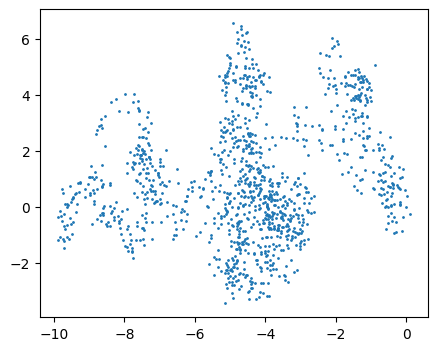

In [119]:
# Create a 10x10 grid
f, ax = plt.subplots(figsize=(5,4))
ax.grid(False)
ax.scatter(x,y, s=1)

In [100]:
# This should match your directory name from above -- you need to change this
dirname = '/home/flybot/DataAnalysis/data/puff_data/puff_data_20230123_131923'
# Class for reading puff data
puff_reader = pps.read_puff_data.PuffReader(dirname)

In [120]:
c=[]
wx=[]
wy=[]
df_new=pd.DataFrame()

for i in range(len(x)):
    concentration, wind_x, wind_y=puff_reader.get_odor_concentration_at_t_and_position(time[i],x[i],y[i])
    c.append(concentration)
    wx.append(wind_x)
    wy.append(wind_y)

In [121]:
df_new['odor']=c
df_new['windx']=wx
df_new['windy']=wy
df_new['x']=x
df_new['y']=x

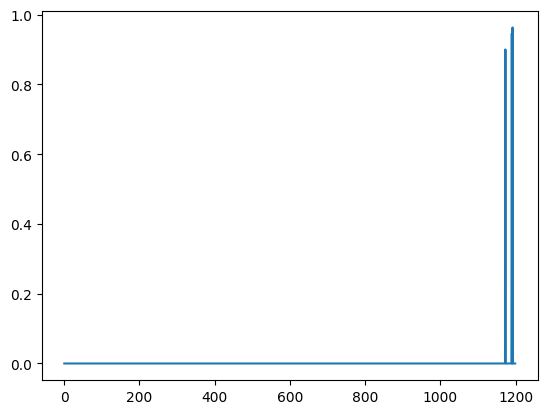

In [122]:
plt.plot(df_new.odor)

In [115]:
traj=pd.read_csv('/home/flybot/DataAnalysis/data/puff_data/sample_trajectory_arunava.csv')

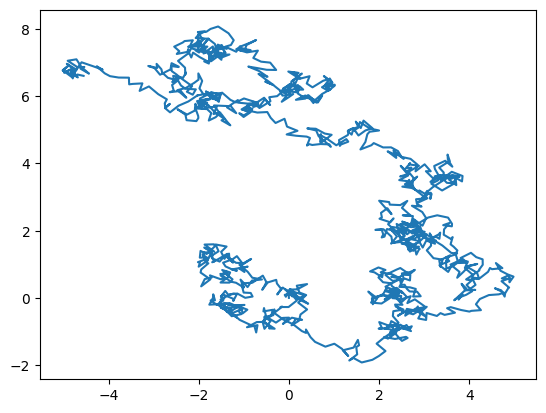

In [112]:
plt.plot(x,y)

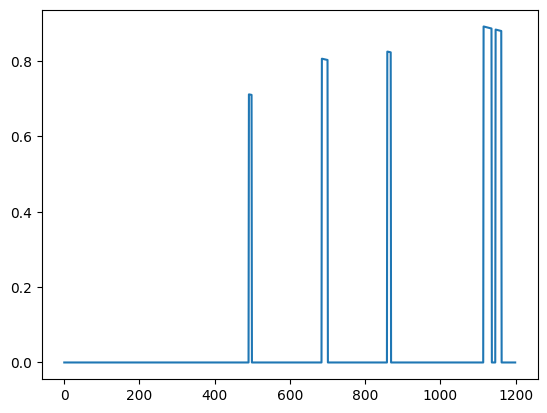

In [111]:
plt.plot(df_new.odor)